In [1]:
%%html
<style>
div.optional {
    display: block;
    background-color: #d7e2ff;
    border-color: #d7e2ff;
    border-left: 5px solid #d7e2ff;
    padding: 0.5em;
}
div.advanced {
    display: block;
    background-color: #fff4d7;
    border-color: #fff4d7;
    border-left: 5px solid #fff4d7;
    padding: 0.5em;
}
</style>

# Modelling & Numerical Methods <a class="tocSkip">

## Finite element methods (FEM) 1 <a class="tocSkip">
    
### Homework exercises <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Homework" data-toc-modified-id="Homework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework</a></span><ul class="toc-item"><li><span><a href="#Some-more-complex-BVP-solutions-using-the-FEM" data-toc-modified-id="Some-more-complex-BVP-solutions-using-the-FEM-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some more complex BVP solutions using the FEM</a></span><ul class="toc-item"><li><span><a href="#An-example-with-a-more-complex-RHS-with-homogeneous-Dirichlet-BCs-[$\star$]" data-toc-modified-id="An-example-with-a-more-complex-RHS-with-homogeneous-Dirichlet-BCs-[$\star$]-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>An example with a more complex RHS with homogeneous Dirichlet BCs [$\star$]</a></span></li><li><span><a href="#Dealing-with-more-complex-BCs-(Inhomogeneous-Dirichlet)--[$\star$]" data-toc-modified-id="Dealing-with-more-complex-BCs-(Inhomogeneous-Dirichlet)--[$\star$]-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Dealing with more complex BCs (Inhomogeneous Dirichlet)  [$\star$]</a></span></li><li><span><a href="#Dealing-with-more-complex-BCs-(Neumann-conditions)--[$\star$]" data-toc-modified-id="Dealing-with-more-complex-BCs-(Neumann-conditions)--[$\star$]-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Dealing with more complex BCs (Neumann conditions)  [$\star$]</a></span></li></ul></li><li><span><a href="#Homework---Solving-on-a-non-uniform-mesh" data-toc-modified-id="Homework---Solving-on-a-non-uniform-mesh-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Homework - Solving on a non-uniform mesh</a></span></li><li><span><a href="#Homework---A-BVP-with-an-inhomogeneous-RHS-and-inhomogeneous-Dirichlet-BCs" data-toc-modified-id="Homework---A-BVP-with-an-inhomogeneous-RHS-and-inhomogeneous-Dirichlet-BCs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Homework - A BVP with an inhomogeneous RHS and inhomogeneous Dirichlet BCs</a></span></li><li><span><a href="#Homework---Another-BVP-with-a-slightly-more-complex-RHS" data-toc-modified-id="Homework---Another-BVP-with-a-slightly-more-complex-RHS-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Homework - Another BVP with a slightly more complex RHS</a></span></li><li><span><a href="#Homework---A-more-complex-BVP-(method-of-manufactured-solutions)" data-toc-modified-id="Homework---A-more-complex-BVP-(method-of-manufactured-solutions)-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Homework - A more complex BVP (method of manufactured solutions)</a></span></li><li><span><a href="#Homework---A-problem-with-non-constant-coefficients-[$\star\star$]" data-toc-modified-id="Homework---A-problem-with-non-constant-coefficients-[$\star\star$]-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Homework - A problem with non-constant coefficients [$\star\star$]</a></span></li><li><span><a href="#Homework---Approximation-using-a-discontinuous-function-[$\star$]" data-toc-modified-id="Homework---Approximation-using-a-discontinuous-function-[$\star$]-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Homework - Approximation using a discontinuous function [$\star$]</a></span></li><li><span><a href="#Homework---Errors-in-function-approximation-[$\star$]" data-toc-modified-id="Homework---Errors-in-function-approximation-[$\star$]-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Homework - Errors in function approximation [$\star$]</a></span></li></ul></li></ul></div>

In [2]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

In [3]:
# some useful functions from the lecture

def hat_function(i, x_nodes):
    """ Top hat basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (x_nodes[i+1] - x)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (x - x_nodes[i-1])/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (x-x_nodes[i-1])/dx[i-1], (x_nodes[i+1]-x)/dx[i] ] ,0.0)
    return hat

def hat_function_deriv(i, x_nodes):
    """ Top hat basis function derivative at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ -1/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ 1/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ 1/dx[i-1], -1/dx[i] ] ,0.0)
    return hat

def mass_matrix(x):
    dx = np.diff(x)
    M = np.zeros((len(x), len(x)))
    M[1:-1,1:-1] = np.diag(dx[:-1]/3  +  dx[1:]/3 , k=0) 
    M += np.diag(dx/6   , k=-1) + np.diag(dx/6   , k=1)
    M[0,0] = dx[0]/3
    M[-1,-1] = dx[-1]/3
    return M


# don't need the composite version of Simpson's rule here - want the version
# that is able to integrate over a single interval and evaluates the function
# at the two end points as well as the mid point
def simpsons_rule(a, b, function, number_intervals=10):
    """ Function to evaluate Simpson's rule. 
    
    Note that this implementation takes the function as an argument, 
    and evaluates this at the midpoint of subintervals in addition to the 
    end point. Hence additional information is generated and used through 
    additional function evaluations. 
    
    This is different to the function/implementation available with SciPy  
    where discrete data only is passed to the function. 
    
    Bear this in mind when comparing results - there will be a factor of two
    in the definition of "n" we need to be careful about!
    
    Also note that this version of the function performs redundant function 
    evaluations - see the **composite** implementation below.
    """

    interval_size = (b - a)/number_intervals

    assert interval_size > 0
    assert type(number_intervals) == int

    I_S = 0.0

    # Loop to valuate Simpson's formula over each interval 
    for i in range(number_intervals):
        # Find a, c, and b
        this_bin_start = a + interval_size * (i)
        this_bin_mid = this_bin_start + interval_size/2
        this_bin_end = this_bin_start + interval_size
        # Calculate the rule and add to running total.
        I_S += (interval_size/6) * (function(this_bin_start) +
                                  4 * function(this_bin_mid) + function(this_bin_end))

    # Return our running total result
    return I_S

def simpsons_composite_rule(a, b, function, number_intervals=10):
    """Function to evaluate the composite Simpson's rule only using
    function evaluations at (number_intervals + 1) points.
    
    This implementation requires that the number of subintervals (number_intervals) be even
    """
    assert number_intervals % 2 == 0, "number_intervals is not even"

    interval_size = (b - a) / number_intervals
    # start with the two end member values
    I_cS2 = function(a) + function(b)

    # add in those terms with a coefficient of 4
    for i in range(1, number_intervals, 2):
        I_cS2 += 4 * function(a + i * interval_size)

    # and those terms with a coefficient of 2
    for i in range(2, number_intervals-1, 2):
        I_cS2 += 2 * function(a + i * interval_size)

    return I_cS2 * (interval_size / 3.0)


# now a function to reconstruct the p/w linear function
def pwlinear(x_nodes, y_nodes, x):
    """Function to return f_h(x) at locations given in x, 
    with top hat functions on a mesh given by x_nodes, and
    corresponding weights given in y_nodes.
    """
    val = np.zeros_like(x)
    # loop over x values, equivalently the basis functions
    for i in range(len(x)):
        # which mesh node is directly to the left of x[i] ?
        node = np.where( x[i] >= x_nodes )[0][-1]
        # because of the greater than or equals above, deal with problem of hitting last node
        node = np.minimum(len(x_nodes)-2,node)
        # add together the contributions from the two hat functions at this x location - 
        # the hat functions centred on "node" (to the left)
        phi_node = hat_function(node, x_nodes)
        # and "node+1" (to the right)
        phi_node_plus_1 = hat_function(node+1, x_nodes)
        # now take the weighted sum of these two hat functions
        val[i] = y_nodes[node]*phi_node(x[i]) + y_nodes[node+1]*phi_node_plus_1(x[i])
    return val

# Homework


## Some more complex BVP solutions using the FEM

We now go through some further examples of solving BVPs with more complex RHS and/or BCs.

The following is just here as a read through of some more complex cases - there aren't specific questions to answer.

<div class="optional">

### An example with a more complex RHS with homogeneous Dirichlet BCs [$\star$]

Now let's consider an example of a problem with a more complex $f$ and hence solution.

The complexity of $f$ means we have more to do when evaluating the RHS vector, but still having homogeneous Dirichlet BCs means we don't have to change the LHS.

</div>

error (RMS at nodes only) =  5.160570601460748e-06


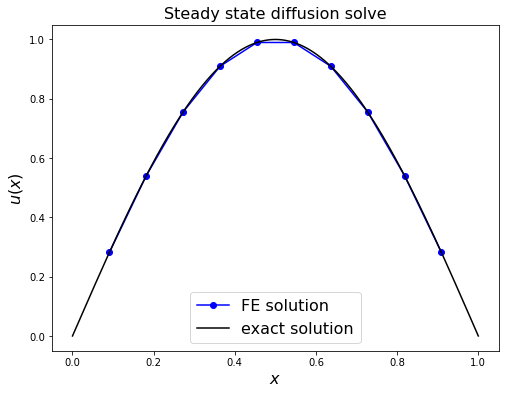

In [4]:
# Note that this is essentially an MMS - we define the solution first that satisfies the BCs
# and then substitute into the BVP to find the appropriate RHS source term

def u_exact(x):
    return np.sin(np.pi*x)

def f(x):
    # just -u''
    return (np.pi**2)*np.sin(np.pi*x)

N_elements_CG = 11
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)
# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
RHS = np.zeros(N_nodes_CG - 2)

K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)

# form RHS vector by integrating function f multiplied by basis function
# loop over internal nodes
for node in range(1, N_nodes_CG - 1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )
    # NB. if we increase the number of intervals we can get arbitrarily 
    # small errors at the nodes

# now we have our equation for the unknowns (K @ u=RHS) solve for u:
u = sl.solve(K,RHS)

# plot the result
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:-1], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, u_exact(x_fine), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS at nodes only) = ', 
      sl.norm(u - u_exact(x_nodes[1:-1]) )
      /np.sqrt(len(u)) )

<div class="optional">

#### A convergence analysis

Let's check how the error converges with $\Delta x$.

We will compute the RMS error at the nodes only (as above), but will also evaluate both the exact solution and the p/w linear numerical approximation on a finer mesh and compute the RMS error of the difference - this will be an approximation to the L2 error.

</div>

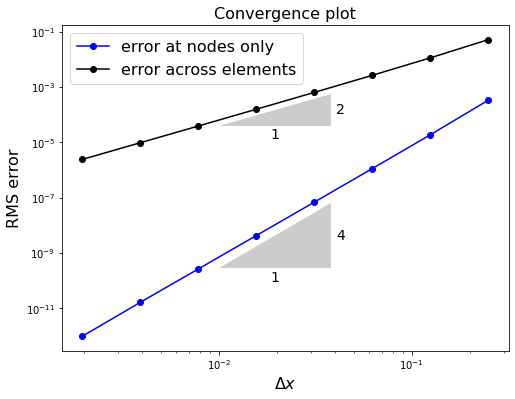

In [5]:
def u_exact(x):
    return np.sin(np.pi*x)

def f(x):
    # just -u''
    return (np.pi**2)*np.sin(np.pi*x)

# some meshes of increasingly finer resolution to loop over
Ns = [2**p for p in range(2, 10)]
errors = np.zeros((2,len(Ns)))

for i, N in enumerate(Ns):
    N_elements_CG = N
    N_nodes_CG = N_elements_CG + 1

    x_nodes = np.linspace(0, 1 , N_nodes_CG )
    dx = np.diff(x_nodes)
    # space to store our discretisaton matrices
    K = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
    RHS = np.zeros(N_nodes_CG - 2)

    K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
        - np.diag(1. / dx[1:-1]   , k=-1) \
        - np.diag(1. / dx[1:-1]   , k=1)

    # form RHS vector by integrating function f multiplied by basis function
    # loop over internal nodes
    for node in range(1, N_nodes_CG - 1):
        # and integrate our function multiplied by the corresponding cts basis function  
        phi_i = hat_function(node, x_nodes)
        integrand = lambda x : f(x) * phi_i(x)
        RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )

    u = sl.solve(K,RHS)

    # RMS error of the nodal errors - cf. comments in main lecture text
    errors[0,i] = sl.norm(u - u_exact(x_nodes[1:-1])) / np.sqrt(len(u)) 
    # now let's do the RMS on a fine mesh to approximate the L2 norm
    x_fine = np.linspace(x_nodes[1],x_nodes[-2],1000)
    errors[1,i] = sl.norm(pwlinear(x_nodes[1:-1], u, x_fine) - u_exact(x_fine)) \
                        / np.sqrt(len(x_fine))
    
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$\Delta x$', fontsize=16)
ax1.set_ylabel('RMS error', fontsize=16)
ax1.set_title('Convergence plot', fontsize=16)
ax1.loglog(1./np.array(Ns), errors[0,:], 'bo-', label='error at nodes only')
ax1.loglog(1./np.array(Ns), errors[1,:], 'ko-', label='error across elements')
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((1e-2, 4e-5), (2, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((1e-2, 3e-10), (4, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

<div class="optional">

#### Comments

So our solver is 4th order accurate in terms of the nodal values, while it is second order accurate in the norm we really care about here - the L2 norm (which we approximate via RMS evaluated in a fine mesh).

</div>

<div class="optional">

### Dealing with more complex BCs (Inhomogeneous Dirichlet)  [$\star$]

Now let's see what we need to do in the case that the BCs are non-zero.

</div>

<div class="optional">

#### Problem description

Now let's consider a BVP problem we considered in a previous lecture (specifically the diffusion only case with fixed values at the end points - recall the exact solution to the problem was a linear that joined the two boundary condition values).

Find $u\equiv u(x)$ which satisfies the ODE over the interval $[0,1]$

$$-u'' = f,$$

for a given source term $\,f$, with inhomogeneous Dirichlet boundary conditions:

$$ u(0) = u_L, \;\;\;\; u(1) = u_R.$$

We'll seek to code up the general case, although to match L7 we are interested in a case with $\,f\equiv 0\,$, $\,u_L=0\,$ and $\,u_R=1$.

</div>

<div class="optional">

#### Finite element approximation

In this case we write our solution as

$$u_h := \sum_{j=0}^{N} u_j\,\phi_j 
= \sum_{j=1}^{N-1} u_j\,\phi_j + u_0\,\phi_0 + u_N\,\phi_N,$$

where $\phi_0$ and $\phi_n$ are defined as per the other basis functions (i.e. $\phi_0$ is unity at node 0 (the boundary) and zero elsewhere), and we choose $u_0=u_L$ and $u_N=u_R$.  These additional components are hence essentially interpolating the prescribed boundary data.

So we are still actually solving for the internal degrees of freedom:  $u_j$, for $j=1,\ldots,N-1$.  

This means that it is still appropriate for us to use the reduced space $V_h^0$ to test our solution against, i.e. we again ignore the boundary terms in the weak form and ask that

$$\int_0^1 u_h'\,\phi_i' \,dx 
= \int_0^1 f\,\phi_i \,dx, \;\;\;\;\; \text{for}\;\;\;\; i=1, 2,\ldots, N-1. $$

Note a difference now though that our $u_h$ does include known $\phi_0 $ and $\phi_n$ terms. Let's see now how this affects things.

In this case the integral in the LHS can be written as 

\begin{align*}
\int_0^1 u_h'\phi_i' \,dx 
&= 
\int_0^1 \,\left(\sum_{j=0}^{N} u_j\,\phi_j'\right)\phi_i' \,dx \\[10pt]
&= 
\sum_{j=0}^{N} u_j\, \int_0^1 \,\phi_j'\,\phi_i' \,dx \\[10pt]
&= 
\sum_{j=1}^{N-1} u_j\, \int_0^1 \phi_i'\, \phi_j' \,dx 
+u_0\, \int_0^1 \phi_i'\, \phi_0' \,dx
+u_n\, \int_0^1 \phi_i'\, \phi_N' \,dx,
\;\;\;\;\; \text{for}\;\;\;\; i=1, 2,\ldots, N-1.
\end{align*}

Note that we will move the (two) boundary term contributions on to the right hand side as they are known. 

We explain in the code that follows how these additional contributions are added into the RHS vector.

Our left hand side "discretisation" matrix is the same $(N-1)\times (N-1)$ matrix as above (the original full $K$ without the first and last rows)

while the RHS vector has entries

$$ b_{i} = \int_0^1 f\, \phi_i \,dx
-u_0\, \int_0^1 \phi_i'\, \phi_0' \,dx
-u_n\, \int_0^1 \phi_i'\, \phi_N' \,dx,
\;\;\;\;\; \text{for}\;\;\;\; i = 1, 2,\ldots, N-1.$$

Our discretised system is again $\,K\boldsymbol{u} = \boldsymbol{b}$.

If we solve this matrix equation for the coefficients $\boldsymbol{u}$ then we have a numerical solution to our problem.

</div>

error (RMS at nodes only) =  3.142637229273806e-16


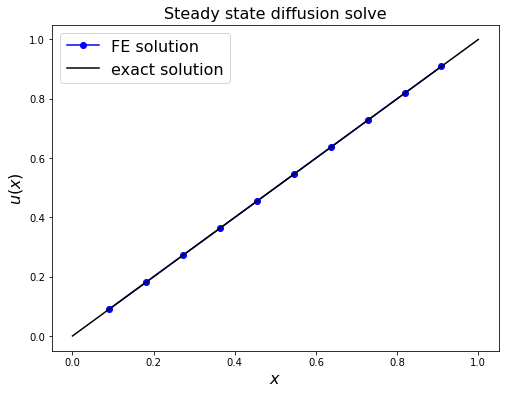

In [6]:
uL = 0.
uR = 1.

def f(x):
    return 0.0

def u_exact(x):
    return uL + x*(uR-uL)


N_elements_CG = 11
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)
# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
RHS = np.zeros(N_nodes_CG - 2)

K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)

# form RHS vector by integrating function f multiplied by basis function
# loop over internal nodes
for node in range(1, N_nodes_CG - 1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # simpsons with number intervals = 2 can integrate this exactly
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )

    
# Add in the extra entries due to the inhomogeneous BCs

# At the left the integral is only non-zero when d(phi_i)/dx and d(phi_0)/dx both have
# support - this only occurs over the first element when i=1 (remembering that i=0
# isn't in our trial space. The integrand is then the value u(0) = uL
# multiplied by the derivative of \phi_1 in the first cell (1/dx[0])
# multiplied by the derivative of \phi_0 in the first cell (-1/dx[0]).
# Overall this is a constant, and hence to do the integral we just need to 
# multiply it by the size of the cell (dx[0]), and subtract the result from the
# current RHS entry for this node:
RHS[0] = RHS[0] - (uL * 1/dx[0] * (-1/dx[0]))*dx[0]

# and similarly for the RHS - we need to update the final entry
RHS[-1] = RHS[-1] - (uR * (-1/dx[-1]) * (1/dx[-1]))*dx[-1]

# now solve
u = sl.solve(K,RHS)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:-1], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, u_exact(x_fine), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS at nodes only) = ', 
      sl.norm(u - u_exact(x_nodes[1:-1]) )
      /np.sqrt(len(u)) )

<div class="optional">

### Dealing with more complex BCs (Neumann conditions)  [$\star$]

One of the big advantages of the FEM is that realistic (i.e. physically meaningful) BCs are relatively easy to incorporate.  

Let's consider Neumann conditions (i.e. specifying the value of the derivative at the boundaries)
which will see can ***naturally*** be incorporated into our FEM formulation, but in a very different way to how we deal with Dirichlet conditions.
    
Let's actually consider a problem with one Dirichlet and one Neumann BC.

</div>

<div class="optional">

#### Problem description

Find $u\equiv u(x)$ which satisfies the ODE over the interval $[0,1]$

$$-u'' = f,$$

for a given source term $\,f$, with an inhomogeneous Dirichlet boundary condition at the left
and an inhomogeneous Nemuann BC at the right:

$$ u(0) = u^D_L, \;\;\;\; u'(1) = u^N_{R}.$$


NB. for this particular ODE problem specifying **two** Neumann conditions yields an ill-posed problem - why is this?


#### Variational form of problem

In this case we integrate by parts 

$$
-\int_0^1 u''\,v \,dx = \int_0^1 u'\,v' \,dx - \left[u'(x)\,v(x)\right]_0^1 = \int_0^1 f\,v \,dx,
$$

and keep the boundary integral on those parts of the domain where the Neumann condition is applied (we drop the boundary contribution at the Dirichlet boundary for the same reasons as in the previous example):

$$
\int_0^1 u'\,v' \,dx = \int_0^1 f\,v \,dx +  u^N_{R}\,v(1) ,
$$

where we have substituted in our known Neumann data: $\,u'(1)= u^N_{R}$ and used the fact that we enforce the Dirichlet with test functions with the property that $v(0)=0$.

</div>

#### Aside: homogeneous Neumann boundary conditions

Note that the *homogeneous* form of Neumann conditions are especially easy to deal with, we simply do not perform the boundary integration.

**Doing nothing** is the correct implementation of the boundary condition for the correct underlying problem (i.e. variational) formulation.

So if in our very first example where we applied homogeneous Dirichlet BCs by actually solving over $i,j = 1,\ldots, N-1$.  If we had solved for $i,j = 0,\ldots, N$ while ignoring the boundaries, we would have effectively solved a version of the problem with homogeneous Neumann BCs (which would have led to a singular matrix for this particular problem due to this issue with two homogeneous Neumann conditions explained above).

<div class="optional">

#### Finite element approximation

In this case we write our solution as

$$u_h := \sum_{j=0}^{N} u_j\,\phi_j 
= \sum_{j=1}^{n} u_j\,\phi_j + u_0\,\phi_0.$$

Note that explicit here is that fact that we don't know our solution at the right hand boundary (and hence we need to solve for $u_N$). We thus strip out the $u_0$ term and define our test function space correspondingly to be that spanned by $\phi_i$ for $i=1, 2,\ldots, N$. We will thus end up solving in this case a $N\times N$ system.

Our variational form is in this case

$$\int_0^1 u_h'\,\phi_i' \,dx 
= \int_0^1 f\,\phi_i \,dx + u_R^N\,\delta_{i,N}, \;\;\;\;\; \text{for}\;\;\;\; i=1, 2,\ldots, N. $$

$\delta_{i,n}$ is the [*Kronecker delta*](https://en.wikipedia.org/wiki/Kronecker_delta) which is equal to one when $i=n$, otherwise it is zero. This is introduced here simply to emphasise that the Neumann boundary data contributes as a boundary integral at the right hand boundary node (i.e. $i=n$) only.

In this case the integral in the LHS can be written as 

\begin{align*}
\int_0^1 u_h'\phi_i' \,dx 
&= 
\int_0^1 \left(\sum_{j=0}^{N} u_j\,\phi_j'\right)\phi_i' \,dx \\[10pt]
&= 
\sum_{j=1}^{N} u_j\, \int_0^1 \phi_i'\, \phi_j' \,dx 
+u_0\, \int_0^1 \phi_i'\, \phi_0' \,dx,
\;\;\;\;\; \text{for}\;\;\;\; i=1, 2,\ldots, N.
\end{align*}

As before we will move the boundary Dirichlet contribution over to the right hand side as it is known.

Our "discretisation" matrix $K$ in this case keep the final row of the full $K$ we originally defined, but does not include the first row.


and

$$ b_{i-1} = \int_0^1 f\, \phi_i \,dx + u^N_{R}\delta_{i,N}
-u_0\, \int_0^1 \phi_i'\, \phi_0' \,dx,
\;\;\;\;\; \text{for}\;\;\;\; i = 1, 2,\ldots, N.$$

So now in this case we have to add into $\boldsymbol{b}$ a term corresponding to the Dirichlet condition, as well as the Neumann condition.  We explained how to deal with the Dirichlet term in a previous example. As we will see in the code below adding in the Neumann term is especially easy.

</div>

error (RMS at nodes only) =  8.149528741558731e-16


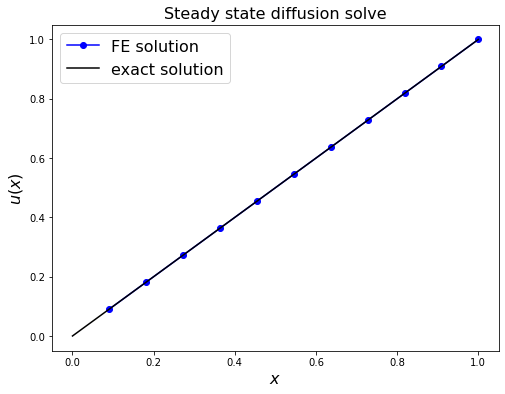

In [7]:
uL = 0.
uRn = 1.

def f(x):
    return 0.0

def u_exact(x):
    return uL + uRn*x

N_elements_CG = 11
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)
# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG - 1, N_nodes_CG - 1))
RHS = np.zeros(N_nodes_CG - 1)

K[:-1,:-1] = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)
# add in the extra bottom right entries
K[-1,-1] = 1. / dx[-1]
K[-1,-2] = -1. / dx[-1]
K[-2,-1] = -1. / dx[-1]

# form RHS vector by integrating function f multiplied by basis function
# loop over internal nodes
for node in range(1, N_nodes_CG-1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # simpsons with number intervals = 2 can integrate this exactly
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )

# need to add in the right hand boundary contribution to the RHS vector
# only contribution comes from the final element
phi_i = hat_function(N_nodes_CG-1, x_nodes)
integrand = lambda x : f(x) * phi_i(x)
RHS[-1] = simpsons_rule(x_nodes[-2], x_nodes[-1], integrand, 1 )
    
# Add in the extra entries due to the inhomogeneous BCs

# At the left the integral is only non-zero when phi_i and phi_0 both have
# support - this only occurs over the first element. The integrand is then
# uL multiplied by the derivative of \phi_1 in the first cell (1/dx[0])
# multiplied by the derivative of \phi_0 in the first cell (-1/dx[0]).
# This is a constant, and hence to do the integral we just need to 
# multiply by the size of the cell (dx[0]):
RHS[0] = RHS[0] - (uL * 1/dx[0] * (-1/dx[0]))*dx[0]

# And finally, now also add a Neumann condition at the right - 
# note we're perform a boundary integral here
RHS[-1] = RHS[-1] + uRn

    

u = sl.solve(K,RHS)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, u_exact(x_fine), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS at nodes only) = ', 
      sl.norm(u - u_exact(x_nodes[1:]) )
      /np.sqrt(len(u)) )

## Homework - Solving on a non-uniform mesh

We saw that for the initial BVP problem we considere in the class (homogeneous Dirichlet conditions with $f\equiv 1$) that the solution we obtained with exact (to round-off) at the nodes.

Confirm that this exactness is no longer true on a non-uniform mesh - try perturbing our internal nodes (i.e. keep the boundaries where they should be!)  a small random amount.

## Homework - A BVP with an inhomogeneous RHS and inhomogeneous Dirichlet BCs

Consider the problem 

$$-u'' = f, $$

with

$$ f \equiv -1,$$

and BCs

$$u(0)=0, \;\;\;\; u(1)=1.$$

First derive the exact solution (integrate up twice and use the BCs to fix the constants of integration), and then use this solution to verify an appropriately implemented FEM solution.

## Homework - Another BVP with a slightly more complex RHS

Consider the problem

$$u'' = x \;\;\;\;\;\;\text{or}\;\;\; -u'' = -x.$$

Integrate up twice to obtain the exact solution with two arbitrary constants of integration.

Consider the domain and use the the boundary conditions

$$u(0) = 0, \;\;\;\;\;\; u(1)=1,$$

to fix the values of the two constants in your exact solution.

Solve the problem using the finite element method and compare with your exact solution.

## Homework - A more complex BVP (method of manufactured solutions)

Consider the solution function

$$ u(x) = -6 x + x^3 + \frac{5}{\sin(1)}\sin(x). $$

Verify that $u(0)=0$ and $u(1)=0$ for this function.

Compute

$$ f := u'' + u.$$

Solve the problem 

$$ u'' + u = f,$$

with the $f$ you've calculated on the interval $[0,1]$, with homogeneous Dirichlet BCs.


If you computed $f$ correctly, and implemented your solver correctly, you should be able to demonstrate convergence to the exact solution we started with.

[Hint: the solver for this problem involve use of the discretisation matrix $A$ we've used multiple times for simple BVPs, along with the mass matrix $M$].


<div class="advanced">

## Homework - A problem with non-constant coefficients [$\star\star$]

The next step in complexity is thinking about how we would go about solving problems with non-constant coefficients.

The added complexity here is that we need to incorporate the variation of coefficients when we compute the entries of the LHS discretisation matrices

For example consider the general diffusion like problem

$$ -(au')' = f, $$

where $a\equiv a(x)$ is a potentially non-constant diffusion coefficient.

Consider diffusion of heat in a bar where $f(x)$ represents a hear source and $a(x)$ represents the heat conductivity.

Suppose we are in the interval $I=[0,1]$ with the completely general [*Robin boundary conditions*](https://en.wikipedia.org/wiki/Robin_boundary_condition)

$$ au'(0) = C_L\,(u(0) - g_L), \;\;\;\;\; au'(1) = C_R\,(u(1) - g_R).$$

The parameters $C_L$ and $C_R$ can be used to control the relative contributions of the Dirichlet and Neumann conditions, with $g_L$ and $g_R$ the applied value of the BC.  For example, in the limit of $C$ being small we recover a homogeneous Neumann condition (and we are free to choose the $C$'s to be zero of course), and in the large limit we approximate a Dirichlet BC.  Note that this means if we implement a general solver with these Robin BC, through the choice of $C$ very large or very small (or actually zero), we approximate the implementation of these BCs.

Try developing a solver for this case and apply it to a problem where the diffusivity is given by

$$ a(x) = 0.1(1 - 0.5x),$$

the source by

$$ f(x) = 10(x - 0.6)^4,$$

and with the BCs

$$u(0) = -1, \;\;\;\;\; u'(1) = 0.$$

</div>

<div class="optional">

## Homework - Approximation using a discontinuous function [$\star$]

We saw in the lecture how to approximate a given function using a p/w linear **continuous** function via $L^2$ projection (which involved deriving the system with the mass matrix and solving for the weights in our expansion in terms of the basis functions).

We can generalise this to a case where we approximate our given function with a p/w linear **discontinuous** function.  This essentially means that instead of having one unknown at every node, we actually have two, each of which "belongs" to the element either side of the mesh vertex.

We thus have more degrees of freedom to solve for (so we expect an improved solution), and need to think about the appropriate set of test functions to use to obtain the appropriately sizes square discrete system to solve.  To do this we simply split our basis functions so each of them is only half of the hat function.

Suggest you take a look at my solution and try to follow what is going on.

</div>

<div class="optional">

## Homework - Errors in function approximation [$\star$]

Now compute the $L^2$ norms of the errors in the three different approximations from the previous question.

</div>